In [23]:
## Compute the persistence homology of blowup chain complex
import numpy as np
import matplotlib.pyplot as plt
import cechmate as cm
from persim import plot_diagrams
import tadasets
import phat
import itertools
import matplotlib.pyplot as plt

#import gudhi
from persim.visuals import plot_diagrams

# Compute standard persistence
Example of computing the global PD of simplicial complex K
```
 K:   0-1-2-3
```
Copied from the source code of function cm.solver.phat_diagrams(). 

``` 
dgm = cm.solver.phat_diagrams(ordered_simplices ,show_inf=True)
``` 

In [24]:

# assume all simplices appear at once at t=0
ordered_simplices =  [ ([0],0),([1],0),([2],0),([3],0),([0,1],0),([1,2],0),([2,3],0)]

## Setup boundary matrix and reduce
columns = cm.solver._simplices_to_sparse_pivot_column(ordered_simplices)
print("boundary of each simplex",columns)
boundary_matrix = phat.boundary_matrix(
    columns=columns , representation=phat.representations.sparse_pivot_column
)
pairs = boundary_matrix.compute_persistence_pairs()
pairs.sort() 

## Setup persistence diagrams by reading off distances
dgms = _process_distances(pairs,ordered_simplices,True )
print("persistence pairs")
for p in pairs:
    print(p)

dgms = _add_unpaired(dgms, pairs, ordered_simplices)

print("persistence dgm")
print(dgms)


boundary of each simplex [(0, []), (0, []), (0, []), (0, []), (1, [0, 1]), (1, [1, 2]), (1, [2, 3])]
persistence pairs
(1, 4)
(2, 5)
(3, 6)
persistence dgm
{0: [[0, 0], [0, 0], [0, 0], [0, inf]]}


- four persistence pairs identified
- only one non-trivial homology classes identified, corresponding to a single connected component 


# 

# Compute localized homology using blowup chain complex

## Functions
Redefine some functions in cm.solver to compute the blowup chain complex

In [140]:
def _process_distances(pairs, ordered_simplices,show_diag=False,cover=None):
    """ Setup persistence diagrams by reading off distances
    new options:
    - show_diag: keep persistence pairs with birth=death
    - cover: a list of length =len(ordered_simplices) to get the subset label of each simplex
    """ 
    dgms = {}
    # identify each simplex as a creator (1) or destroyer (-1)
    posneg = np.zeros(len(ordered_simplices))

    for [bi, di] in pairs:
        bidxs, bd = ordered_simplices[bi]  # get birth time (timestep of the creator)
        didxs, dd = ordered_simplices[di]  # get death time (timestep of the corresponding destroyer)
        assert posneg[bi] == 0 and posneg[di] == 0
        posneg[bi], posneg[di] = 1, -1     # set creator and destroyer

        assert dd >= bd
        # assert len(bidxs) == len(didxs) - 1

        p = len(bidxs) - 1    # get the dimension of this cycle (todo: use dim(sigma)+dim(Deltq) )

        if cover:
            # Don't add zero persistence pairs
            if bd != dd or  show_diag:
                dgms.setdefault(p,[]).append( [bd,dd,cover[bi]]) 
        else:
            # Don't add zero persistence pairs
            if bd != dd or  show_diag:
                dgms.setdefault(p, []).append([bd, dd])  # remove persistence pair if death = birth (on the diagonal)  
    return dgms

In [141]:
def _add_unpaired(dgms, pairs, simplices,cover=None):
    posneg = np.zeros(len(simplices))
    for [bi, di] in pairs:
        assert posneg[bi] == 0
        assert posneg[di] == 0
        posneg[bi] = 1
        posneg[di] = -1

    for i in range(len(posneg)):
        if posneg[i] == 0:
            (idxs, dist) = simplices[i]
            p = len(idxs) - 1
            if not p in dgms:
                dgms[p] = []
            if cover:
                dgms[p].append([dist, np.inf,cover[i]])
            else:
                dgms[p].append([dist, np.inf])

    return dgms

In [142]:

def max_non_infinite(numbers):
    # Filter out infinite values
    finite_numbers = [num for num in numbers if num != float('inf')  ]
    if not finite_numbers:
        return 10
    return max(finite_numbers)
    
def plotbarcode_BC(dgms,dim,coverlabel2id):
    persistence = [ [coverlabel2id[c],(b,d)]  for b,d,c in dgms[dim] ]
    labels = [ c for b,d,c in dgms[dim]]
    
    _, axes = plt.subplots(1, 1,figsize=(4,1.5))
    colormap = plt.cm.Set1.colors
    print(persistence)
    
    death = [d for b,d,c in dgms[dim]]
    
    largest_non_infinite = max_non_infinite( death )
    
    infinity  = largest_non_infinite*1.5
    
    x = [birth for (dim, (birth, death)) in persistence]
    y = [(death - birth) if death != float("inf") else (infinity - birth) for (dim, (birth, death)) in persistence]
    c = [colormap[dim] for (dim, (birth, death)) in persistence]
    
    axes.barh(range(len(x)), y, left=x, alpha=0.5, color=c, linewidth=0,label=labels)
    plt.axvline(x=infinity , color='red', linestyle='--') 
    #axes.set_xticks(labels)
    axes.legend()
    axes.set_title("Persistence barcode", fontsize=12)
    axes.set_yticks([])   #axes.invert_yaxis()
    #xticks = axes.get_xticklabels();    xticks[-1] = '\inf';axes.set_xticklabels(xticks)
    plt.show()

In [200]:
def compute_blowup(ordered_simplices, columns,cover ,show_diag=False):
    if show_diag:
        print('display h classes on diagonal')
    coverlabel2id = dict([ (c,i) for i,c in enumerate(set(cover)) ])
    ## Setup boundary matrix and reduce

    boundary_matrix = phat.boundary_matrix(
        columns=columns , representation=phat.representations.sparse_pivot_column
    )
    pairs = boundary_matrix.compute_persistence_pairs()
    pairs.sort()
    
    # compute persistence pairs (hide diagonals to make it easier to read)
    dgms =  _process_distances(pairs, ordered_simplices,show_diag,cover)
    for p in pairs:
        print(p)
    print(dgms)
    dgms =  _add_unpaired(dgms, pairs, ordered_simplices,cover)
    
    #coverlabel2id = {"0":0,"1":1,"01":2 }
    for dim,dgm in dgms.items(): 
        print('H%d'%dim,dgm )
        plotbarcode_BC(dgms,dim,coverlabel2id )  
    return dgms
    

## Example in the paper

### 1.A linear chain with two covers 

```
X:    0-1-2-3
X0:   0-1-2  
X1:     1-2-3
X[1]:   1-2
```
The covers are glued by standard simplex $\Delta^J$
```
D[1]:   0-1
```
Input simplicial complex are stored in `ordered_simplices` as $( \sigma, t)$ pairs


display h classes on diagonal
(1, 3)
(2, 4)
(5, 10)
(6, 8)
(7, 9)
(11, 12)
{0: [[0, 0, '0'], [0, 0, '0'], [0, 1, '1'], [0, 0, '1'], [0, 0, '1']], 1: [[1, 1, '01']]}
H0 [[0, 0, '0'], [0, 0, '0'], [0, 1, '1'], [0, 0, '1'], [0, 0, '1'], [0, inf, '0']]
[[2, (0, 0)], [2, (0, 0)], [0, (0, 1)], [0, (0, 0)], [0, (0, 0)], [2, (0, inf)]]


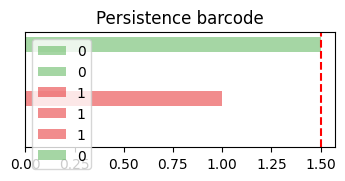

H1 [[1, 1, '01']]
[[1, (1, 1)]]


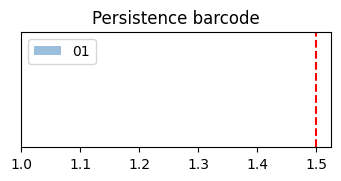

In [144]:
# the actual labeling of simplies doesn't affect the computation
# the important information is the dimension of simplices (sigma x delta) 
# and timestep t

ordered_simplices =  [ ([0],0),([1],0),([2],0),([0,1],0),([1,2],0) , #X0xD0 
                      ([1],0),([2],0),([3],0),([1,2],0),([2,3],0), #X1xD1 
                      ([1,0],1),([2,0],1),([1,2,0 ],1)] # X[1]xD[1] pad zeros to fill up dimension

# manually define the nonzero entries in the columns of boundary matrix  
# TODO: construct automatically using the product boundary operator

columns = [(0,[]), #0 [0]x[0]
           (0,[]), #1 [1]x[0]
           (0,[]), #2 [2]x[0]
           (1,[0,1]), #3 [01]x[0]
           (1,[1,2]), #4 [12]x[0]
           (0,[]), #5 [1]x[1]
           (0,[]), #6 [2]x[1]
           (0,[]), #7 [3]x[1]
           (1,[5,6]), #8 [12]x[1]
           (1,[6,7]), #9 [23]x[1]
           (1,[1,5]), #10 [1]x[01]
           (1,[2,6]), #11 [2]x[01]
           (2,[4,8,10,11])] #12 [12]x[01]

cover = [  '0','0','0','0','0','1','1','1','1','1','1','01','01','01'] 
compute_blowup(ordered_simplices, columns,cover ,True) 


### 2. Three triangles with two covers 
```
  X:   1--3
      / \/ \
     0--2--4
 X0: (0,1,2,3)
 X1: (1,2,3,4)
 X[1]: (1,2,3)
```
The covers are glued by standard simplex $\Delta^J=$   [0,1] 

display h classes on diagonal
(1, 4)
(2, 5)
(3, 7)
(9, 18)
(10, 13)
(11, 14)
(12, 16)
(15, 23)
(19, 21)
(20, 22)
{0: [[0, 0, '0'], [0, 0, '0'], [0, 0, '0'], [0, 1, '1'], [0, 0, '1'], [0, 0, '1'], [0, 0, '1']], 1: [[0, 1, '1'], [1, 1, '01'], [1, 1, '01']]}
H0 [[0, 0, '0'], [0, 0, '0'], [0, 0, '0'], [0, 1, '1'], [0, 0, '1'], [0, 0, '1'], [0, 0, '1'], [0, inf, '0']]
[[2, (0, 0)], [2, (0, 0)], [2, (0, 0)], [0, (0, 1)], [0, (0, 0)], [0, (0, 0)], [0, (0, 0)], [2, (0, inf)]]


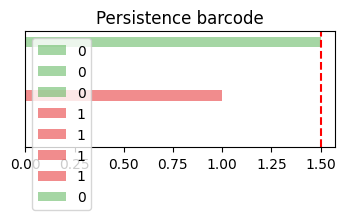

H1 [[0, 1, '1'], [1, 1, '01'], [1, 1, '01'], [0, inf, '0'], [0, inf, '0'], [0, inf, '1']]
[[0, (0, 1)], [1, (1, 1)], [1, (1, 1)], [2, (0, inf)], [2, (0, inf)], [0, (0, inf)]]


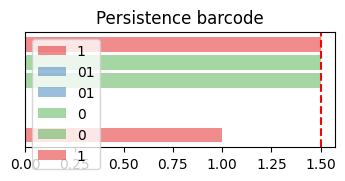

In [145]:
ordered_simplices=  [([0],0),([1],0),([2],0),([3],0),([0,1],0),([0,2],0),([1,2],0),([1,3],0),([2,3],0), #X0xD0 
                      ([1],0),([2],0),([3],0),([4],0),([1,2],0),([1,3],0),([2,3],0),([2,4],0),([3,4],0), #X1xD1 
                      ([1,0],1),([2,0],1),([3,0],1),([1,2,0],1),([1,3,0],1),([2,3,0],1)] # X[1]xD[1]
columns = [(0,[]),  
           (0,[]),  
           (0,[]),  
           (0,[]),
           (1,[0,1]),  
           (1,[0,2]),  
           (1,[1,2]),  
           (1,[1,3]),  
           (1,[2,3]), 
           (0,[]),  
           (0,[]),  
           (0,[]),  
           (0,[]), 
           (1,[9,10]), 
           (1,[9,11]), 
           (1,[10,11]), 
           (1,[10,12]),  
           (1,[11,12]),  
           
           (1,[1,9]), 
           (1,[2,10]),  
           (1,[3,11]),  
           (2,[6,13,18,19]),  
           (2,[7,14,18,20]),  
           (2,[8,15,19,20])]  


cover =   [ '0']*9 +[ '1']*9  + ['01']*6   # label simplices by their cover subset
compute_blowup(ordered_simplices, columns,cover ,True)

### 3. Two triangles with two covers 

```
 X:    1--3
      / \/ 
     0--2
 X0: (0,1,2)
 X1: (1,2,3)
 X[1]: (1,2)
```


display h classes on diagonal
(1, 3)
(2, 4)
(6, 12)
(7, 9)
(8, 10)
(13, 14)
{0: [[0, 0, '0'], [0, 0, '0'], [0, 1, '1'], [0, 0, '1'], [0, 0, '1']], 1: [[1, 1, '01']]}
H0 [[0, 0, '0'], [0, 0, '0'], [0, 1, '1'], [0, 0, '1'], [0, 0, '1'], [0, inf, '0']]
[[2, (0, 0)], [2, (0, 0)], [0, (0, 1)], [0, (0, 0)], [0, (0, 0)], [2, (0, inf)]]


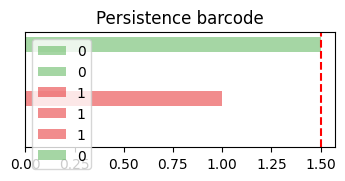

H1 [[1, 1, '01'], [0, inf, '0'], [0, inf, '1']]
[[1, (1, 1)], [2, (0, inf)], [0, (0, inf)]]


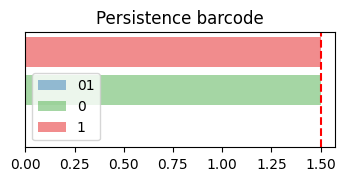

In [146]:
ordered_simplices =   [([0],0),([1],0),([2],0),([0,1],0),([0,2],0),([1,2],0), #X0xD0 
                       ([1],0),([2],0),([3],0), ([1,2],0),([1,3],0),([2,3],0) , #X1xD1 
                       ([1,0],1),([2,0],1), ([1,2,0],1) ] # X[1]xD[1]

columns = [(0,[]),  
           (0,[]),   
           (0,[]),
           (1,[0,1]),  
           (1,[0,2]),  
           (1,[1,2]),  
           (0,[]),  
           (0,[]),  
           (0,[]),   
           (1,[6,7]), 
           (1,[6,8]), 
           (1,[7,8]), 
           (1,[1,6]),  
           (1,[2,7]),   
           (2,[5,9,12,13])]  
## Setup boundary matrix and reduce

boundary_matrix = phat.boundary_matrix(
    columns=columns , representation=phat.representations.sparse_pivot_column
)
pairs = boundary_matrix.compute_persistence_pairs()
pairs.sort()



## Setup persistence diagrams by reading off distances
cover =   [ '0']*6 +[ '1']*6  + ['01']*3   # label simplices by their cover subset
compute_blowup(ordered_simplices, columns,cover,True ) 

When the overlap is an edge, H0 is reduced by 1 at time t=1, but H1 is unchanged

### 4. A single point covered by three sets  
```
 X:    0 
 X0: (0)
 X1: (0)
 X2: (0)
 X[01]: (1)
 X[12]: (1)
 X[02]: (1) 
 X[012]: (2) 
```

display h classes on diagonal
(1, 3)
(2, 4)
(5, 6)
{0: [[0, 1, '1'], [0, 1, '2']], 1: [[1, 2, '02']]}
H0 [[0, 1, '1'], [0, 1, '2'], [0, inf, '0']]
[[5, (0, 1)], [0, (0, 1)], [4, (0, inf)]]


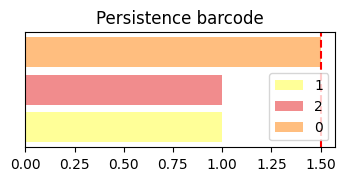

H1 [[1, 2, '02']]
[[6, (1, 2)]]


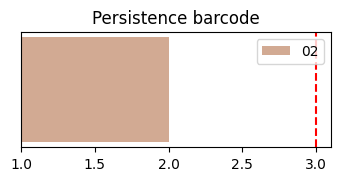

In [147]:
ordered_simplices =  [([0],0),([0],0) ,([0],0),  
                      ([0,0],1),([0,0],1), ([0,0],1),([0,0,0],2)] # X[1]xD[1]

columns = [(0,[]),  
           (0,[]),  
           (0,[]),    
           (1,[0,1]), 
           (1,[1,2]),  
           (1,[0,2]),   
           (2,[3,4,5])      ]  
## Setup boundary matrix and reduce
boundary_matrix = phat.boundary_matrix(
    columns=columns , representation=phat.representations.sparse_pivot_column
)
pairs = boundary_matrix.compute_persistence_pairs()
pairs.sort()

## Setup persistence diagrams by reading off distances
cover =   [ '0','1','2','01','12','02','012']   
compute_blowup(ordered_simplices, columns,cover, show_diag=True) 

## Additional examples

display h classes on diagonal
(1, 2)
(3, 9)
(4, 5)
(6, 10)
(7, 8)
(11, 12)
{0: [[0, 0, '0'], [0, 1, '1'], [0, 0, '1'], [0, 1, '2'], [0, 0, '2']], 1: [[1, 2, '02']]}
H0 [[0, 0, '0'], [0, 1, '1'], [0, 0, '1'], [0, 1, '2'], [0, 0, '2'], [0, inf, '0']]
[[4, (0, 0)], [5, (0, 1)], [5, (0, 0)], [0, (0, 1)], [0, (0, 0)], [4, (0, inf)]]


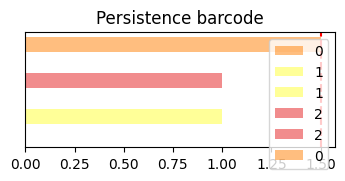

H1 [[1, 2, '02']]
[[6, (1, 2)]]


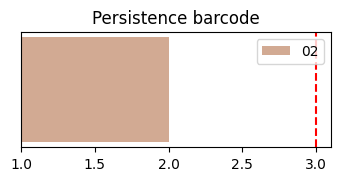

In [148]:
# Example of computing the blowup chain complex of K with two covers 
# X:    0--1--2
#          | 
#          3
# X0: (0,1)
# X1: (1,2)
# X2: (1,2)
# X[01]: (1)
# X[12]: (1)
# X[02]: (1) 

# the actual labeling of simplies doesn't affect the computation
ordered_simplices =  [([0],0),([1],0), ([0,1],0), #X0xD0 
                      ([1],0),([2],0), ([1,2],0) , #X1xD1 
                      ([1],0),([3],0), ([1,3],0),
                      ([1,0],1),([1,0],1), ([1,0],1),([1,0,0],2)] # X[1]xD[1]

columns = [(0,[]),  
           (0,[]),   
           (1,[0,1]), 
           (0,[]),  
           (0,[]),   
           (1,[3,4]),  
           (0,[]),  
           (0,[]),   
           (1,[6,7]), 
           (1,[1,3]),  
           (1,[1,6]),   
           (1,[3,6]),   
           (2,[9,10,11])]   

## Setup persistence diagrams by reading off distances
cover =   [ '0']*3 +[ '1']*3 +[ '2']*3  + ['01','12','02','012' ]   # label simplices by their cover subset
compute_blowup(ordered_simplices , columns,cover ,True) 



display h classes on diagonal
(1, 4)
(2, 5)
(3, 6)
(7, 21)
(8, 11)
(9, 12)
(10, 13)
(14, 24)
(15, 18)
(16, 20)
(17, 19)
(22, 23)
(25, 26)
(28, 29)
{0: [[0, 0, '0'], [0, 0, '0'], [0, 0, '0'], [0, 1, '1'], [0, 0, '1'], [0, 0, '1'], [0, 0, '1'], [0, 1, '2'], [0, 0, '2'], [0, 0, '2'], [0, 0, '2']], 1: [[1, 1, '01'], [1, 1, '02'], [1, 1, '12']]}
H0 [[0, 0, '0'], [0, 0, '0'], [0, 0, '0'], [0, 1, '1'], [0, 0, '1'], [0, 0, '1'], [0, 0, '1'], [0, 1, '2'], [0, 0, '2'], [0, 0, '2'], [0, 0, '2'], [0, inf, '0']]
[[3, (0, 0)], [3, (0, 0)], [3, (0, 0)], [4, (0, 1)], [4, (0, 0)], [4, (0, 0)], [4, (0, 0)], [0, (0, 1)], [0, (0, 0)], [0, (0, 0)], [0, (0, 0)], [3, (0, inf)]]


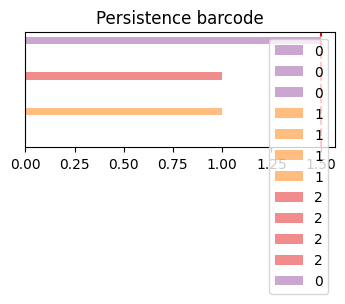

H1 [[1, 1, '01'], [1, 1, '02'], [1, 1, '12'], [1, inf, '12']]
[[1, (1, 1)], [5, (1, 1)], [2, (1, 1)], [2, (1, inf)]]


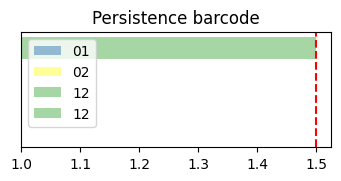

In [149]:
 
# Example of computing the blowup chain complex of K with two covers 
# X:    0--1--2
#       |     |
#       5--4--3
# X0: (0,1,2,3)
# X1: ( 2,3,4,5)
# X2: (0,1,4,5)
# X[01]: (2,3)
# X[02]:(0,1)
# X[12]:(4,5)


# the actual labeling of simplies doesn't affect the computation
ordered_simplices =  [([0],0),([1],0),([2],0),([3],0),([0,1],0),([1,2],0),([2,3],0),  
                      ([2],0),([3],0),([4],0),([5],0) ,([2,3],0),([3,4],0),([4,5],0) ,   
                      ([0],0),([1],0),([4],0),([5],0),([0,1],0),([0,5],0),([4,5],0),
                      ([2,0],1),([3,0],1), ([2,3,0],1) ,  
                      ([4,0],1),([5,0],1), ([4,5,0],1) ,
                      ([0,0],1),([1,0],1), ([0,1,0],1) ]  
                    
columns = [(0,[]),  
           (0,[]),   
           (0,[]),  
           (0,[]),
           (1,[0,1]),  
           (1,[1,2]),  
           (1,[2,3]),  
           (0,[]),  
           (0,[]),  
           (0,[]),  
           (0,[]),    
           (1,[7,8]), 
           (1,[8,9]), 
           (1,[9,10]), 
           (0,[]),  
           (0,[]),  
           (0,[]),  
           (0,[]),    
           (1,[14,15]), 
           (1,[14,17]), 
           (1,[16,17]), 
           (1,[2,7]), 
           (1,[3,8]),  
           (2,[6,11,21,22]),
           (1,[9,16]), 
           (1,[10,17]),  
           (2,[13,20,24,25]),
           (1,[0,14]), 
           (1,[1,15]),  
           (2,[4,18,27,28]) ]  

## Setup persistence diagrams by reading off distances
cover =   [ '0']*7 +[ '1']*7+[ '2']*7 + ['01']*3 +['02']*3+['12']*3    # label simplices by their cover subset
compute_blowup(ordered_simplices , columns,cover,True ) 
